In [1]:
!pip install biopython
!pip install pyvis
!pip install nglview
!jupyter-nbextension enable nglview --py --sys-prefix

Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK


In [2]:
### Import **Libraries**

import os
import os.path
import numpy as np
import subprocess
import math
import time
import pdb
import shutil
import networkx as nx
import nglview as nv
from pyvis.network import Network
import matplotlib.pyplot as plt
import sys
# sys.setrecursionlimit(100000)

_ColormakerRegistry()

In [3]:
from collections import Counter
from Bio.PDB import MMCIFParser, PDBParser, Selection, NeighborSearch

def pdb_model(structure_file, water=False):
    """Return a biopython [1] model entity from a structure file.

    Parameters
    ----------
    structure_file: string
        Path to structure file
    water: boolean (default=False)
        True to take into account waker molecules in the structure, False
        otherwise.

    Notes
    -----
    1. http://biopython.org/wiki/Biopython

    """
    accepted_formats = ['cif', 'pdb', 'ent']
    parsers = [MMCIFParser, PDBParser, PDBParser]
    protein_name, file_format = structure_file.rsplit('.', 1)

    try:
        parser = parsers[accepted_formats.index(file_format)]
        parser = parser(QUIET=True)
    except ValueError:
        raise Exception("Accepted structure files are: {}".format(
            accepted_formats))

    structure = parser.get_structure(protein_name, structure_file)
    model = structure[0]

    if not water:
        for chain in model.get_chains():
            for residue in list(chain):
                hetero_flag = residue.id[0].strip()
                # Empty strings evaluate to False.  Therefore hetero_flag
                # returns False if the residue is not a water molecule.
                if hetero_flag:
                    chain.detach_child(residue.id)
            if not list(chain):
                model.detach_child(chain.id)

    return model


def label_residue(residue):
    """ Return a string of the label of the biopython [1] residue object.

    The label of the residue is the following:
        Chain + Position

    Parameters
    ----------
    residue: Bio.PDB.Residue.Residue
        The residue to be labeled.

    Notes
    -----
    1. http://biopython.org/wiki/Biopython

    """
    position = str(residue.id[1])
    chain = residue.parent.id

    return chain + ' ' + position #added space deliminater for split function.

## Residue adjecmatrixtest

In [4]:
#Biopython used to create adjecency dictionary
def residue_adjacency_CO_test(model, cutoff=5, weight=True):
    """Return residue adjacency dictionary defined by cutoff distance.

    Parameters
    ----------
    model: Bio.PDB.Model
        Model created with the atomic coordinates of the protein file.

    cutoff: int or float
        Distance cutoff defining links between atoms.  Two atoms are adjacent
        if their distance is less than the given cutoff.

    See Also
    --------`````````````
    pdb_model

    """
    #Use only the Atoms specified in paper
    atom_list = Selection.unfold_entities(model, 'A')
    atoms = [atom for atom in atom_list if 'C' in atom.name or 'O' in atom.name]
#     print(atoms)

    neighbor_search = NeighborSearch(atoms)
    atomic_adjacency = {}

    for atom in atoms:
        _res = label_residue(atom.get_parent())
        adjacent_atoms = []
        for adj_atom in neighbor_search.search(atom.coord, cutoff):
            _adj_res = label_residue(adj_atom.parent)
            # Adjacent atoms must be in different residues
            if _adj_res != _res:
                adjacent_atoms.append(adj_atom)
        atomic_adjacency[atom] = adjacent_atoms

    adjacency = {}

    # Create residue adjacency dictionary with string format, see
    # label_residue.
    for atom, neighbors in atomic_adjacency.items():
        residue = label_residue(atom.get_parent())
        adjacency.setdefault(residue, [])

        # Only different residues are connected by an edge (No loops).
        not_in_residue = []
        for neighbor in neighbors:
            neighbor_parent = label_residue(neighbor.get_parent())
            if neighbor_parent is not residue:
                not_in_residue.append(neighbor_parent)

        adjacency[residue].extend(not_in_residue)

    if not weight:

        return adjacency

    # Make new dictionary mapping each residue to its neighbors taking
    # into account the weight.
    weighted_adjacency = {}
    for residue in adjacency:
        counter = Counter(adjacency[residue])
        weighted_adjacency[residue] = {
            neighbor: {'weight': counter[neighbor]}
            for neighbor in counter}

    return weighted_adjacency

In [5]:

def topo_network(model, cutoff=4, weight=True):
    """Return the interaction network of a protein structure.

    The interaction network is defined by a distance cutoff.

    Parameters
    ----------
    model: Bio.PDB.model
        The protein structure.
    cutoff: float
        The distance cutoff defining an interaction between two nodes.
    weight: boolean
        True if atomic interactions are to be considered.
    """

    adjacency_dictionary = residue_adjacency_CO_test(model, cutoff=cutoff,
                                            weight=weight)

    return nx.Graph(adjacency_dictionary)


In [6]:
class Pmolecule(object):
    """Create a Pmolecule object.

    The Pmolecule calls a number of methods for the analysis of protein
    structure. This includes the construction of the interaction network of the
    protein.

    Parameters
    ----------
    structure_file = str
        The path to the structure file of the targeted protein. Three
        structure-file formats are accepted: `pdb', `cif', and `ent'.
    water: boolean, default is False
        If false, water molecules are ignored.

    Attributes
    ----------
    model: Bio.PDB.model
        The structural model of the structure. See www.biopython.org.
    path_to_file: str
        The path to the structural file used to instantiate the class.
    """

    def __init__(self, structure_file, water=False):
        self.model = pdb_model(structure_file, water=water)
        self.path_to_file = structure_file

    def get_network(self, cutoff=5, weight=True):
        """Return the interaction network of a protein structure.

        The interaction network is defined by a distance cutoff.

        Parameters
        ----------
        model: Bio.PDB.model
            The protein structure.
        cutoff: float
            The distance cutoff defining an interaction between two nodes.
        weight: boolean
            True if atomic interactions are to be considered.
        """

        return topo_network(self.model, cutoff=cutoff, weight=weight)

    def get_pdbmodel(self):
        return self.model

## Experimental

In [7]:
def setup():
    p = subprocess.Popen('mkdir -p ./inputdata; mkdir -p ./outputdata; mkdir -p ./predictionResults; cd inputdata; wget https://files.rcsb.org/download/3cln.pdb; echo "3cln" >> list.txt; cat list.txt; cd .. echo "Created all needed folders";', shell=True, stdout=subprocess.PIPE)
    p.wait()
  # print(str(p.communicate()[0], 'utf-8'))

setup()

In [8]:
molecule = Pmolecule('./inputdata/3cln.pdb')
view = nv.show_biopython(molecule.get_pdbmodel())
view.clear_representations()
#view as ball and stick (atom and bond)
view.add_ball_and_stick()
# view.add_licorice('ALA, GLU')

In [9]:
view

NGLWidget()

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


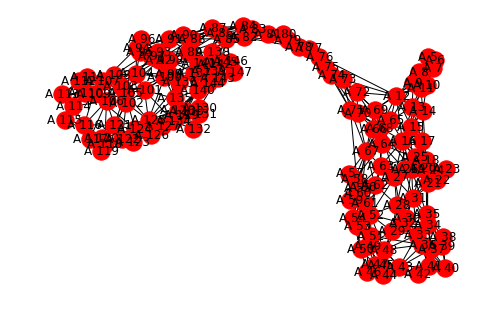

In [10]:
# Create Biograph, uses Biopython for stucture and networkx for drawing the graphs
Graph = molecule.get_network()
nx.draw(Graph, with_labels = True) #, with_labels = True

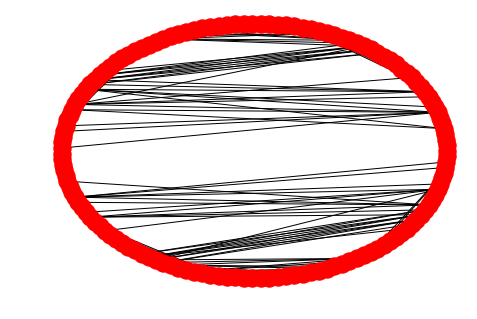

In [11]:
nx.draw_circular(Graph)

In [12]:
vis_net = Network(height="700px", width="100%", notebook=True)

# set the physics layout of the network
vis_net.barnes_hut()
vis_net.from_nx(Graph)
vis_net.show('ex.html')

In [13]:
model = molecule.get_pdbmodel()

In [14]:
adjmatrix = residue_adjacency_CO_test(model, cutoff=4, weight=True)

In [15]:
# adjmatrix

In [16]:
def get_res_cliqs(G, M):
    renamed_cliques=[]
    cliques=[clique for clique in nx.find_cliques(G) if len(clique)>= 4]
    for cliq in cliques:
        c=[]
        for cli in cliq:
            res = M[str(cli.split(' ')[0])][int(cli.split(' ')[1])]
            c.append(res)
        renamed_cliques.append(c)
    print('Number of cliques found: ',len(cliques))
    return(renamed_cliques)

In [32]:
def Label_adjmatrix(adj_m, model):
    answer = {}
    for i, (k, v) in enumerate(adj_m.items()):
        atoms_inres = model[str(k.split(' ')[0])][int(k.split(' ')[1])]
        # print(atoms_inres.get_list())
        for atoms in atoms_inres.get_atoms():
            if 'C' in atoms.name or 'O' in atoms.name:
                k_label = atoms
                answer.update({k_label: v})
                # print(i, k_label, v)
    return answer

In [18]:
def FillResi(G,adj_m, model, cliqueCallback):
    centered_cliq=None
    ress=[res for res in cliqueCallback(G, model)] # add conditions later
    for cliq in ress:
        centered_cliq = ress
    return centered_cliq

#filter each residue with center ca2

In [19]:
t_ans2 = FillResi(Graph, adjmatrix, model, get_res_cliqs)

Number of cliques found:  208


In [20]:
t_ans2

[[<Residue ASP het=  resseq=131 icode= >,
  <Residue GLU het=  resseq=140 icode= >,
  <Residue ASN het=  resseq=129 icode= >,
  <Residue ASP het=  resseq=133 icode= >,
  <Residue GLN het=  resseq=135 icode= >],
 [<Residue ASP het=  resseq=131 icode= >,
  <Residue GLU het=  resseq=140 icode= >,
  <Residue ASN het=  resseq=129 icode= >,
  <Residue ILE het=  resseq=130 icode= >],
 [<Residue ASP het=  resseq=131 icode= >,
  <Residue GLY het=  resseq=132 icode= >,
  <Residue ASN het=  resseq=129 icode= >,
  <Residue ASP het=  resseq=133 icode= >],
 [<Residue ASP het=  resseq=131 icode= >,
  <Residue GLY het=  resseq=132 icode= >,
  <Residue ASN het=  resseq=129 icode= >,
  <Residue ILE het=  resseq=130 icode= >],
 [<Residue LYS het=  resseq=30 icode= >,
  <Residue GLU het=  resseq=31 icode= >,
  <Residue LEU het=  resseq=32 icode= >,
  <Residue GLY het=  resseq=33 icode= >,
  <Residue THR het=  resseq=29 icode= >],
 [<Residue LYS het=  resseq=30 icode= >,
  <Residue GLU het=  resseq=31 icod

In [30]:
t_ans1 = Label_adjmatrix(adjmatrix, model)

In [31]:
t_ans1

{<Atom O>: {'A 6': {'weight': 8},
  'A 8': {'weight': 6},
  'A 9': {'weight': 4},
  'A 7': {'weight': 1}},
 <Atom OG1>: {'A 6': {'weight': 8},
  'A 8': {'weight': 6},
  'A 9': {'weight': 4},
  'A 7': {'weight': 1}},
 <Atom O>: {'A 5': {'weight': 8},
  'A 7': {'weight': 6},
  'A 9': {'weight': 1},
  'A 10': {'weight': 1}},
 <Atom OE1>: {'A 5': {'weight': 8},
  'A 7': {'weight': 6},
  'A 9': {'weight': 1},
  'A 10': {'weight': 1}},
 <Atom OE2>: {'A 5': {'weight': 8},
  'A 7': {'weight': 6},
  'A 9': {'weight': 1},
  'A 10': {'weight': 1}},
 <Atom O>: {'A 6': {'weight': 6},
  'A 8': {'weight': 8},
  'A 5': {'weight': 1},
  'A 11': {'weight': 6},
  'A 10': {'weight': 1}},
 <Atom OE1>: {'A 6': {'weight': 6},
  'A 8': {'weight': 8},
  'A 5': {'weight': 1},
  'A 11': {'weight': 6},
  'A 10': {'weight': 1}},
 <Atom OE2>: {'A 6': {'weight': 6},
  'A 8': {'weight': 8},
  'A 5': {'weight': 1},
  'A 11': {'weight': 6},
  'A 10': {'weight': 1}},
 <Atom O>: {'A 5': {'weight': 6},
  'A 7': {'weight':

In [23]:
# for i, (k, v) in enumerate(t_ans1.items()):
#     print(k, v)
# #     atoms_inres = model[str(k.split(' ')[0])][int(k.split(' ')[1])]
# #     print(atoms_inres)
# #     print(atoms_inres.get_list())
# #     #       data = []
# #     #       for atoms in atoms_inres.get_atoms():
# #     #         if 'C' in atoms.name or 'O' in atoms.name:
# #     #           data.append(atoms.get_coord())
# #     #       print(data)
# #     #       cdata, cmask = clustercentroids(data)
# #     for atoms in atoms_inres.get_atoms():
# #     if 'C' in atoms.name or 'O' in atoms.name:
# #       k_label = atoms
# #     print('Coord: ', atoms.get_coord())
# #     print(i, k_label, v)

## Maximal Cliques, Carbon Clusters

In [24]:
# cliques=[clique for clique in nx.find_cliques(Graph) if len(clique)<=4]
# print('Number of cliques found: ',len(cliques))
# print(cliques)

In [25]:
#Print out the coordinates of all CA atoms in a structure with B factor greater than 50
for chain in model.get_list():
  for residue in chain.get_list():
    if residue.has_id("CA"):
      ca = residue["CA"]
      if ca.get_bfactor() > 50.0:
        print(ca.get_coord())
# For for each carbon alpha in a residue find neigbor oxygen 

[-9.673 31.878 23.853]
[-10.293  29.138  21.24 ]
[-7.196 29.999 19.19 ]
[-4.917 29.856 22.249]
[-6.314 26.41  23.052]
[-5.287 25.541 19.503]
[-1.752 26.96  19.484]
[ 2.294 21.909  8.132]
[-0.327 21.086 10.763]
[-2.833 23.864 10.177]
[-2.095 24.829  6.582]


In [26]:
def FilterTest17(model):
  #finding Ca binding site from remaining max clique residue
  cutoff = 5
  binding_residues = []
  for res in model.get_residues():
      alpha_carbon = res['CA']
      distances = []
      for atom in res:
          #subtract the two position vectors
          diff_vector = alpha_carbon.get_vector() - atom.get_vector()
          #to get a positive value we square the difference vector
          #we then take the square root to go back to the original scale
          distances.append(np.sqrt(np.sum(diff_vector * diff_vector)))
      #we get the nearest atom using min(distances) and see if it falls inside
      #the cutoff
      if min(distances) < cutoff:
          binding_residues.append(res)
  print(binding_residues)

FilterTest17(model)

[<Residue THR het=  resseq=5 icode= >, <Residue GLU het=  resseq=6 icode= >, <Residue GLU het=  resseq=7 icode= >, <Residue GLN het=  resseq=8 icode= >, <Residue ILE het=  resseq=9 icode= >, <Residue ALA het=  resseq=10 icode= >, <Residue GLU het=  resseq=11 icode= >, <Residue PHE het=  resseq=12 icode= >, <Residue LYS het=  resseq=13 icode= >, <Residue GLU het=  resseq=14 icode= >, <Residue ALA het=  resseq=15 icode= >, <Residue PHE het=  resseq=16 icode= >, <Residue SER het=  resseq=17 icode= >, <Residue LEU het=  resseq=18 icode= >, <Residue PHE het=  resseq=19 icode= >, <Residue ASP het=  resseq=20 icode= >, <Residue LYS het=  resseq=21 icode= >, <Residue ASP het=  resseq=22 icode= >, <Residue GLY het=  resseq=23 icode= >, <Residue ASP het=  resseq=24 icode= >, <Residue GLY het=  resseq=25 icode= >, <Residue THR het=  resseq=26 icode= >, <Residue ILE het=  resseq=27 icode= >, <Residue THR het=  resseq=28 icode= >, <Residue THR het=  resseq=29 icode= >, <Residue LYS het=  resseq=30 

In [27]:
# def envclean():
#     p = subprocess.Popen('rm -r ./inputdata; rm -r ./outputdata; rm -r ./predictionResults; "Del all needed folders";', shell=True, stdout=subprocess.PIPE)
#     p.wait()
#   # print(str(p.communicate()[0], 'utf-8'))

# envclean()

In [28]:
! ./clean.sh